In [17]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygsp
import mplleaflet


March 1st: first reported case in New York 
<br>
March 4th: Yeshiva University campus closed, high school in the Bronx 
<br>
March 9th 16 confirmed cases 
<br>
March 10th: mitigation measures expanded (online classes for universities) 
<br>
March 11th: CUNY and SUNY closed
<br>
March 14th: first reported death in New York 
<br>
March 16th: NYC public schools closed 
<br>
March 20th: stay-at-home order for non-essential workers, total over 7000 cases
<br>
March 22nd: shortages of PPE for health workers, recommendation that health facilities stop testing non-hospitalized patients
<br>
March 26th: USNS Comfort heading to NYC to assist local hospitals 


New York Weather : MARCH

[weather data](https://www.timeanddate.com/weather/usa/new-york/historic?month=3&year=2020)

In [18]:
df = pd.read_csv('./data/202003-citibike-tripdata.csv')
n_start_station = len(df['start station id'].unique())
n_end_station = len(df['end station id'].unique())


In [19]:
total_station_id = set(df['start station id']).union(set(df['end station id']))
n_tot_station = len(total_station_id)

In [20]:
id_index = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [21]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1589,2020-03-01 00:00:03.6400,2020-03-01 00:26:32.9860,224,Spruce St & Nassau St,40.711464,-74.005524,3574,Prospect Pl & Underhill Ave,40.676969,-73.965790,16214,Subscriber,1980,1
1,389,2020-03-01 00:00:16.7560,2020-03-01 00:06:46.0620,293,Lafayette St & E 8 St,40.730207,-73.991026,223,W 13 St & 7 Ave,40.737815,-73.999947,29994,Subscriber,1991,2
2,614,2020-03-01 00:00:20.0580,2020-03-01 00:10:34.2200,379,W 31 St & 7 Ave,40.749156,-73.991600,515,W 43 St & 10 Ave,40.760094,-73.994618,39853,Subscriber,1991,1
3,597,2020-03-01 00:00:24.3510,2020-03-01 00:10:22.3390,3739,Perry St & Greenwich Ave,40.735918,-74.000939,325,E 19 St & 3 Ave,40.736245,-73.984738,42608,Subscriber,1989,1
4,1920,2020-03-01 00:00:26.1120,2020-03-01 00:32:26.2680,236,St Marks Pl & 2 Ave,40.728419,-73.987140,3124,46 Ave & 5 St,40.747310,-73.954510,36288,Subscriber,1993,1


# Location Parser #

In [22]:
useful = [3, 5, 6, 7, 9, 10]
df.iloc[:,useful]

,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude
0,224,40.711464,-74.005524,3574,40.676969,-73.965790
1,293,40.730207,-73.991026,223,40.737815,-73.999947
2,379,40.749156,-73.991600,515,40.760094,-73.994618
3,3739,40.735918,-74.000939,325,40.736245,-73.984738
4,236,40.728419,-73.987140,3124,40.747310,-73.954510
...,...,...,...,...,...,...
1068452,422,40.770513,-73.988038,3356,40.774667,-73.984706
1068453,523,40.754666,-73.991382,442,40.746647,-73.993915
1068454,528,40.742909,-73.977061,487,40.733143,-73.975739
1068455,3043,40.681460,-73.934903,3755,40.690648,-73.957462


# Find Locations #

In [23]:
locations = dict()
for e in id_index.keys():
    if df[df['start station id'] == e]['start station latitude'].shape[0]:
        locations[id_index[e]] = (df[df['start station id'] == e]['start station longitude'].iloc[0],
                                  df[df['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations[id_index[e]] = (df[df['end station id'] == e]['end station longitude'].iloc[0],
                                  df[df['end station id'] == e]['end station latitude'].iloc[0])
 

# Parser #

In [24]:
useful = [1, 0, 3, 7, 11, 13, 14]
df.iloc[:,useful]

,starttime,tripduration,start station id,end station id,bikeid,birth year,gender
0,2020-03-01 00:00:03.6400,1589,224,3574,16214,1980,1
1,2020-03-01 00:00:16.7560,389,293,223,29994,1991,2
2,2020-03-01 00:00:20.0580,614,379,515,39853,1991,1
3,2020-03-01 00:00:24.3510,597,3739,325,42608,1989,1
4,2020-03-01 00:00:26.1120,1920,236,3124,36288,1993,1
...,...,...,...,...,...,...,...
1068452,2020-03-31 23:56:06.0490,137,422,3356,18851,1989,2
1068453,2020-03-31 23:57:27.6850,1548,523,442,36539,1993,1
1068454,2020-03-31 23:58:00.2690,308,528,487,43023,1982,1
1068455,2020-03-31 23:58:42.9010,872,3043,3755,43073,1990,1


# Util Functions #

In [25]:
# Find indexes to extract daily rides

def days_index():
    d_i = {}
    for index, row in df.iterrows():
        day = int(row['starttime'].split()[0].split('-')[2])
        if d_i.get(day) is None:
            d_i[day] = index
    return d_i

In [26]:
# Find indexes to extract temporal rides

def hour_rides(first, last):
    d_h = {}
    for index, row in df.iloc[first:last].iterrows():
        hour = int(row['starttime'].split(':')[0][-2:])
        if d_h.get(hour) is None:
            d_h[hour] = [index]
        else:
            d_h[hour].append(index)            
    return d_h

In [27]:
# Dictionary with days starting indexes
"""d = days_index()
with open('./data/variables/march_index.pickle', 'wb') as file:
    pickle.dump(d, file)"""


"d = days_index()\nwith open('./data/variables/march_index.pickle', 'wb') as file:\n    pickle.dump(d, file)"

# MARCH #

In [28]:
# Load day indexes for March
with open('./data/variables/march_index.pickle', 'rb') as file:
    d = pickle.load(file)

In [29]:
d_a = [e for e in d.values()]
d_a.append(df.shape[0])
d_a = np.array(d_a)
rides_day = d_a[1:] - d_a[:-1]

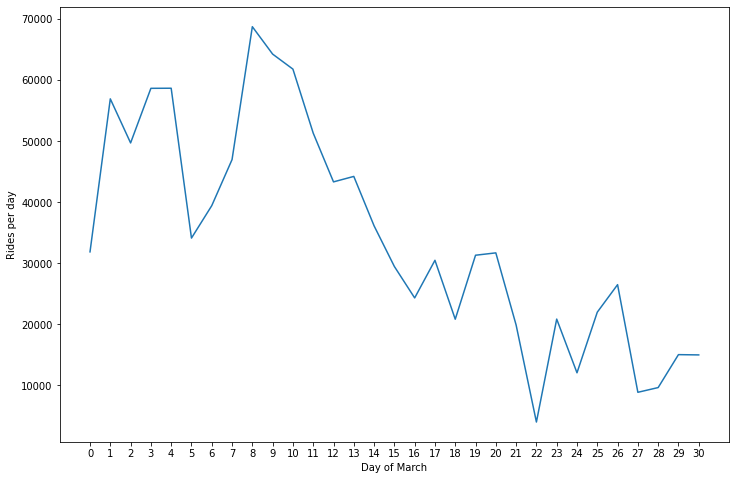

In [30]:
# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(rides_day)
_ = plt.xticks(np.arange(31), np.arange(31))
_ = plt.xlabel("Day of March")
_ = plt.ylabel("Rides per day")

In [31]:
print("Maximum number of rides on day {}".format(np.argmax(rides_day)))
print("With {} rides".format(np.max(rides_day)))

Maximum number of rides on day 8
With 68768 rides


## 2st-6th of March ##

In [32]:
# 2 -> Monday
# Choose day 
days = [2, 3, 4, 5, 6]
#days = [4]

# Find all connections with weights
adj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_2_6_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...


In [33]:
print("Total number of rides : {}".format(np.sum(adj_2_6_tot) / 2))

Total number of rides : 258160.0


In [34]:
adj_2_6 = adj_2_6_tot.copy()
adj_2_6[adj_2_6 > 0] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_2_6) / 2))

for i in range(n_tot_station):
    adj_2_6[i, i] = 0

Unweighted number of rides (edges) : 59188.0


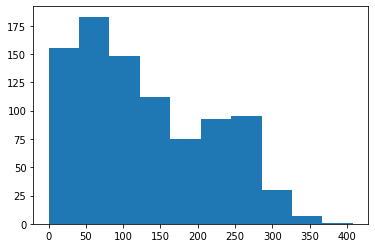

In [35]:
# Create Undirected graph 
g_2_6 = nx.from_numpy_matrix(adj_2_6)
degs_2_6 = np.array([x[1] for x in g_2_6.degree])
_ = plt.hist(degs_2_6)

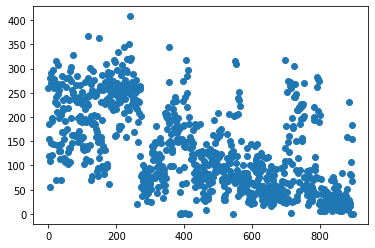

In [36]:
plt.scatter(np.arange(n_tot_station), degs_2_6)

## Plot ##

In [37]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

mplleaflet.show()

### Clustering ###

In [38]:
isolated_nodes_2_6 = []
for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        isolated_nodes_2_6.append(e.pop())

g_2_6.remove_nodes_from(isolated_nodes_2_6)

for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        print(e)

In [39]:
G_2_6 = pygsp.graphs.Graph(nx.adjacency_matrix(g_2_6))

G_2_6.compute_laplacian()
G_2_6.compute_fourier_basis()

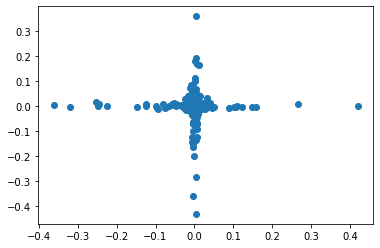

In [40]:
plt.scatter(G_2_6.U[1,:], G_2_6.U[2,:])

In [41]:
nx.write_gexf(g_2_6, "./graphs/g_2_6.gexf")

In [42]:
nx.algorithms.cluster.average_clustering(g_2_6)

0.4433088952321857

## 9th-13th of March ##

In [43]:
# 9 -> Monday
# Choose day 
days = [9, 10, 11, 12, 13]
#days = [11]

# Find all connections with weights
adj_9_13_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_9_13_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_9_13_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 9 loaded...
Day 10 loaded...
Day 11 loaded...
Day 12 loaded...
Day 13 loaded...


In [44]:
print("Total number of rides : {}".format(np.sum(adj_9_13_tot) / 2))

Total number of rides : 289536.0


In [45]:
adj_9_13 = adj_9_13_tot.copy()
adj_9_13[adj_9_13 > 0] = 1
print("Unweighted number of rides : {}".format(np.sum(adj_9_13) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_9_13[i, i] = 0

Unweighted number of rides : 70933.5


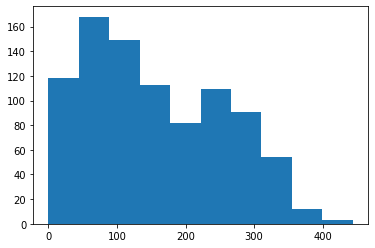

In [46]:
# Create Undirected graph 
g_9_13 = nx.from_numpy_matrix(adj_9_13)
degs_9_13 = np.array([x[1] for x in g_9_13.degree])
_ = plt.hist(degs_9_13)

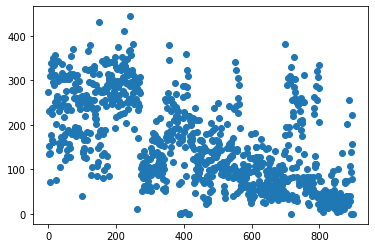

In [47]:
plt.scatter(np.arange(n_tot_station), degs_9_13)

## Plot ##

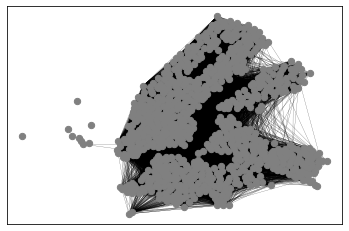

In [48]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [49]:
isolated_nodes_9_13 = []
for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        isolated_nodes_9_13.append(e.pop())

g_9_13.remove_nodes_from(isolated_nodes_9_13)

for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        print(e)

In [50]:
G_9_13 = pygsp.graphs.Graph(nx.adjacency_matrix(g_9_13))

G_9_13.compute_laplacian()
G_9_13.compute_fourier_basis()

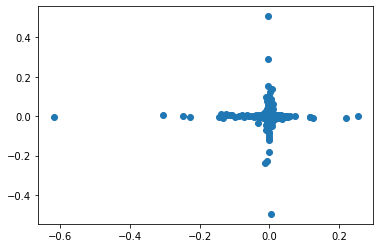

In [51]:
plt.scatter(G_9_13.U[1,:], G_9_13.U[2,:])

In [52]:
nx.algorithms.cluster.average_clustering(g_9_13)

0.46510119862397076

## 16th-20th of March ##

In [53]:
# 16 -> Monday
# Choose day 
days = [16, 17, 18, 19, 20]
#days = [18]

# Find all connections with weights
adj_16_20_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_16_20_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_16_20_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 16 loaded...
Day 17 loaded...
Day 18 loaded...
Day 19 loaded...
Day 20 loaded...


In [54]:
print("Total number of rides : {}".format(np.sum(adj_16_20_tot) / 2))

Total number of rides : 136477.0


In [55]:
adj_16_20 = adj_16_20_tot.copy()
adj_16_20[adj_16_20 > 0] = 1
print("Unweighted number of rides : {}".format(np.sum(adj_16_20) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_16_20[i, i] = 0

Unweighted number of rides : 48135.0


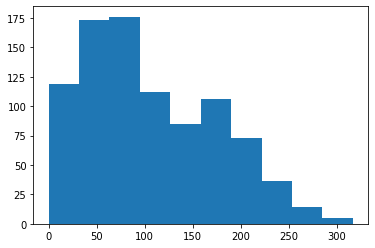

In [56]:
# Create Undirected graph 
g_16_20 = nx.from_numpy_matrix(adj_16_20)
degs_16_20 = np.array([x[1] for x in g_16_20.degree])
_ = plt.hist(degs_16_20)

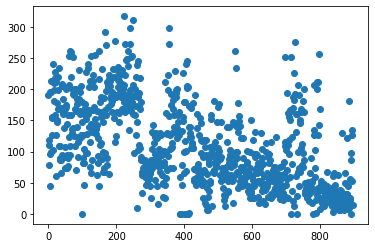

In [57]:
plt.scatter(np.arange(n_tot_station), degs_16_20)

## Plot ## 

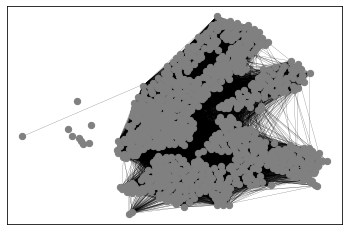

In [58]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [59]:
isolated_nodes_16_20 = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20.append(e.pop())

g_16_20.remove_nodes_from(isolated_nodes_16_20)

for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

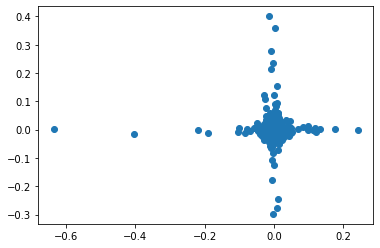

In [60]:
G_16_20 = pygsp.graphs.Graph(nx.adjacency_matrix(g_16_20))

G_16_20.compute_laplacian()
G_16_20.compute_fourier_basis()

plt.scatter(G_16_20.U[1,:], G_16_20.U[2,:])

In [61]:
nx.algorithms.cluster.average_clustering(g_16_20)

0.3661494958775159

## 23st-27th of March ##

In [62]:
# 23 -> Monday
# Choose day 
days = [23, 24, 25, 26, 27]
#days = [24]

# Find all connections with weights
adj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_23_27_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...


In [63]:
print("Total number of rides : {}".format(np.sum(adj_23_27_tot) / 2))

Total number of rides : 85428.0


In [64]:
adj_23_27 = adj_23_27_tot.copy()
adj_23_27[adj_23_27 > 0] = 1
print("Unweighted number of rides : {}".format(np.sum(adj_23_27) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_23_27[i, i] = 0

Unweighted number of rides : 34634.5


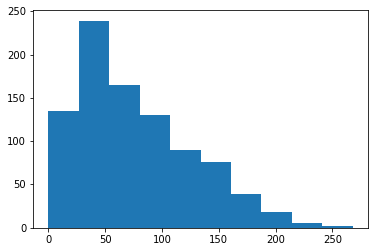

In [65]:
# Create Undirected graph 
g_23_27 = nx.from_numpy_matrix(adj_23_27)
degs_23_27 = np.array([x[1] for x in g_23_27.degree])
_ = plt.hist(degs_23_27)

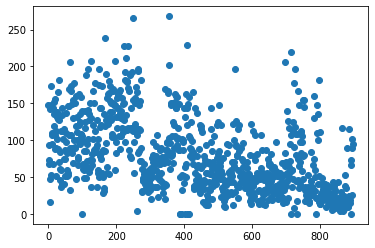

In [66]:
plt.scatter(np.arange(n_tot_station), degs_23_27)

## Plot ##

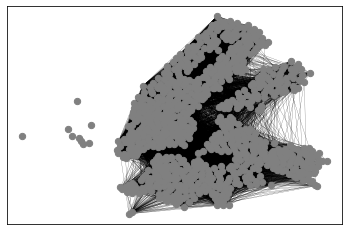

In [67]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [68]:
isolated_nodes_23_27 = []
for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        isolated_nodes_23_27.append(e.pop())

g_23_27.remove_nodes_from(isolated_nodes_23_27)

for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        print(e)

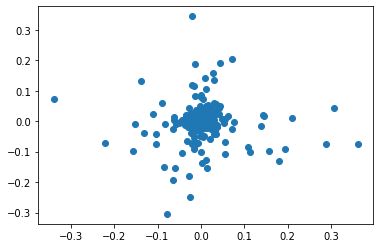

In [69]:
G_23_27 = pygsp.graphs.Graph(nx.adjacency_matrix(g_23_27))

G_23_27.compute_laplacian()
G_23_27.compute_fourier_basis()

plt.scatter(G_23_27.U[1,:], G_23_27.U[2,:])

In [70]:
nx.algorithms.cluster.average_clustering(g_23_27)

0.30332337421400735

## Deg-Sorted Nodes over time ##

In [71]:
sort_deg = np.argsort(degs_2_6)

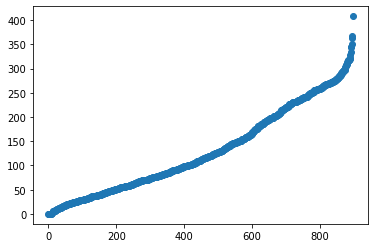

In [72]:
plt.scatter(np.arange(n_tot_station), degs_2_6[sort_deg])

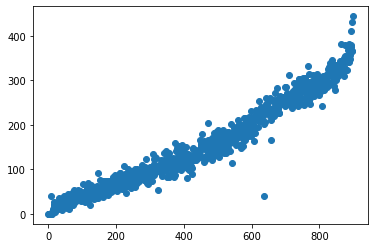

In [73]:
plt.scatter(np.arange(n_tot_station), degs_9_13[sort_deg])

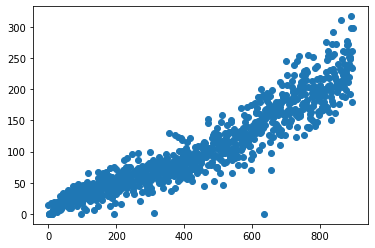

In [74]:
plt.scatter(np.arange(n_tot_station), degs_16_20[sort_deg])

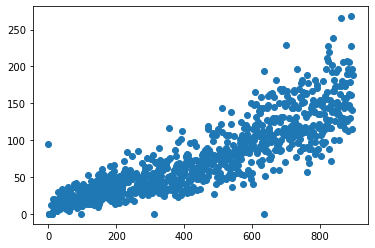

In [75]:
plt.scatter(np.arange(n_tot_station), degs_23_27[sort_deg])

# Function analysis #

## Rides Functions 2-6 ##

In [76]:
# ATTENTION !!!
adj_2_6_tot = np.delete(adj_2_6_tot, isolated_nodes_2_6, 0)
adj_2_6_tot = np.delete(adj_2_6_tot, isolated_nodes_2_6, 1)

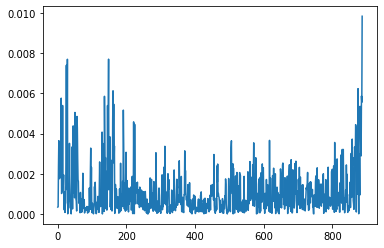

In [77]:
f_2_6 = np.sum(adj_2_6_tot, axis=0)

# Compute number of access per stations

f_2_6_spect = np.dot(G_2_6.U.T, f_2_6)
f_2_6_spect /= np.sum(np.abs(f_2_6_spect))

plt.plot(np.abs(f_2_6_spect[1:]))

## Rides Functions 9-13 ##

In [78]:
# ATTENTION !!!
adj_9_13_tot = np.delete(adj_9_13_tot, isolated_nodes_9_13, 0)
adj_9_13_tot = np.delete(adj_9_13_tot, isolated_nodes_9_13, 1)

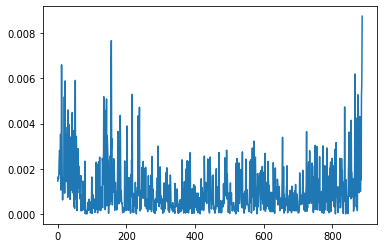

In [79]:
f_9_13 = np.sum(adj_9_13_tot, axis=0)
## Rides Functions 9-13 ##

# Compute number of access per stations

f_9_13_spect = np.dot(G_9_13.U.T, f_9_13)
f_9_13_spect /= np.sum(np.abs(f_9_13_spect))

plt.plot(np.abs(f_9_13_spect[1:]))

## Rides Functions 6-20 ##

In [80]:
# ATTENTION !!!

adj_16_20_tot = np.delete(adj_16_20_tot, isolated_nodes_16_20, 0)
adj_16_20_tot = np.delete(adj_16_20_tot, isolated_nodes_16_20, 1)

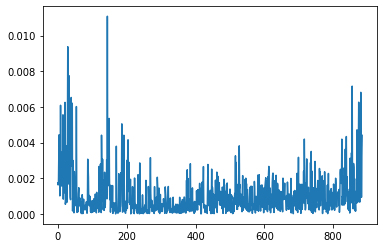

In [81]:

f_16_20 = np.sum(adj_16_20_tot, axis=0)

# Compute number of access per stations

f_16_20_spect = np.dot(G_16_20.U.T, f_16_20)
f_16_20_spect /= np.sum(np.abs(f_16_20_spect))

plt.plot(np.abs(f_16_20_spect[1:]))

## Rides Functions 23-27 ##

In [82]:
# ATTENTION !!!

adj_23_27_tot = np.delete(adj_23_27_tot, isolated_nodes_23_27, 0)
adj_23_27_tot = np.delete(adj_23_27_tot, isolated_nodes_23_27, 1)

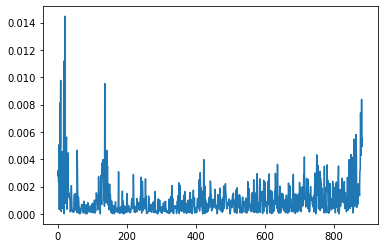

In [83]:
f_23_27 = np.sum(adj_23_27_tot, axis=0)

# Compute number of access per stations

f_23_27_spect = np.dot(G_23_27.U.T, f_23_27) 
f_23_27_spect = f_23_27_spect / np.sum(np.abs(f_23_27_spect))

plt.plot(np.abs(f_23_27_spect[1:]))

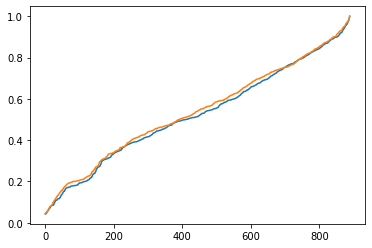

In [84]:
plt.plot(np.cumsum(np.abs(f_2_6_spect)))
plt.plot(np.cumsum(np.abs(f_9_13_spect)))

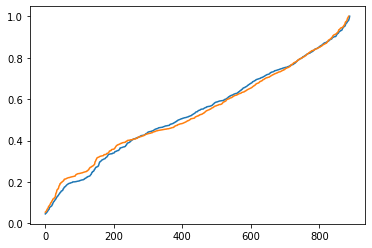

In [85]:
plt.plot(np.cumsum(np.abs(f_9_13_spect)))
plt.plot(np.cumsum(np.abs(f_16_20_spect)))

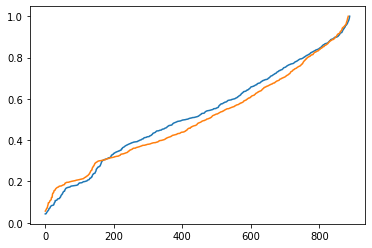

In [86]:
plt.plot(np.cumsum(np.abs(f_2_6_spect)))
plt.plot(np.cumsum(np.abs(f_23_27_spect)))

# Functions on Graphs #

In [87]:
d_2_6 = np.delete(degs_2_6, isolated_nodes_2_6)
d_9_13 = np.delete(degs_9_13, isolated_nodes_9_13)
d_16_20 = np.delete(degs_16_20, isolated_nodes_16_20)
d_23_27 = np.delete(degs_23_27, isolated_nodes_23_27)

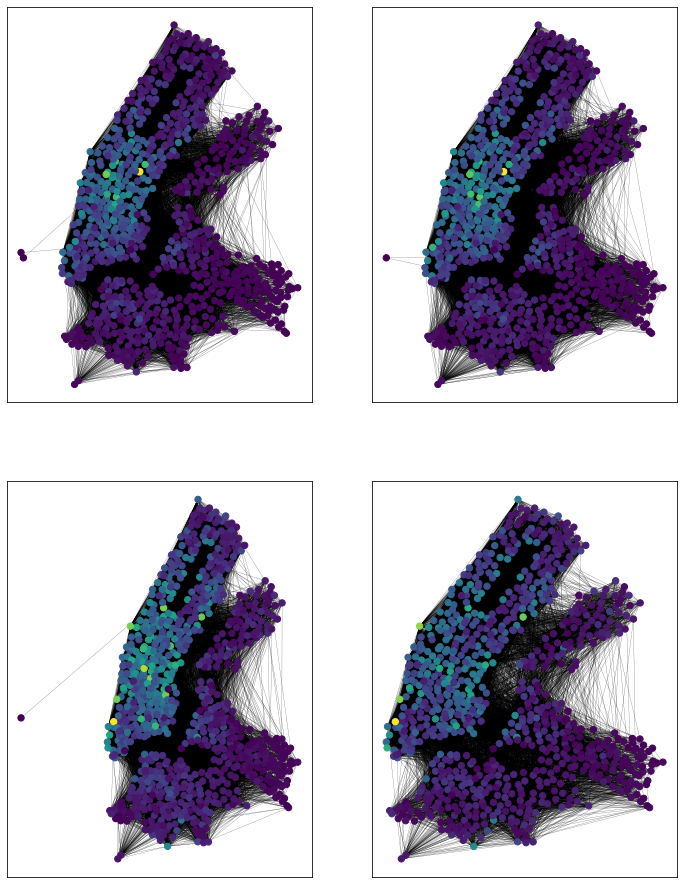

In [88]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=f_2_6)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=f_9_13)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=f_16_20)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=f_23_27)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')



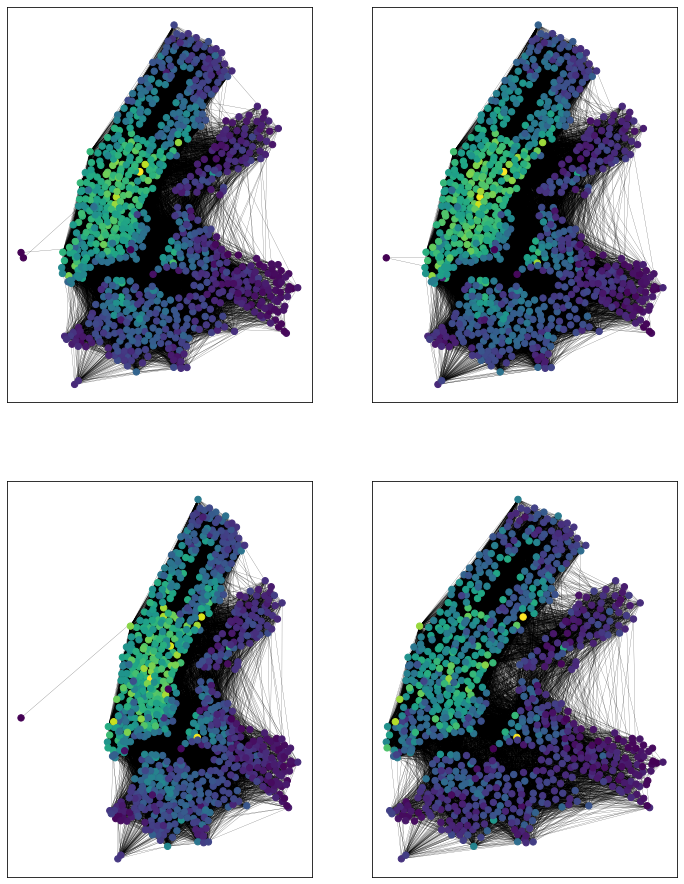

In [89]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=d_2_6)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=d_9_13)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=d_16_20)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=d_23_27)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

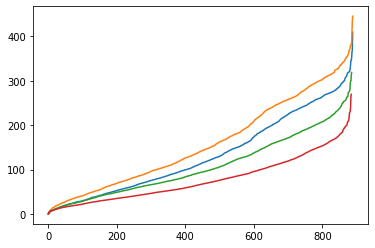

In [90]:
plt.plot(G_2_6.e)
plt.plot(G_9_13.e)
plt.plot(G_16_20.e)
plt.plot(G_23_27.e)

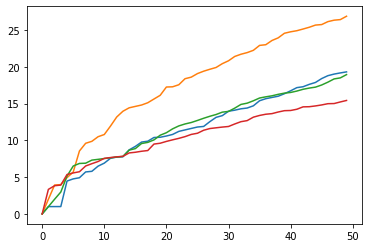

In [91]:
plt.plot(G_2_6.e[:50])
plt.plot(G_9_13.e[:50])
plt.plot(G_16_20.e[:50])
plt.plot(G_23_27.e[:50])

In [92]:
G_2_6.e[:10]

array([0.        , 0.99518205, 0.99617977, 0.99913777, 4.46457982,
       4.75912227, 4.91399977, 5.70298707, 5.78759537, 6.4891346 ])

In [93]:
G_9_13.e[:10]

array([ 0.        ,  1.99134157,  3.92292798,  3.98095492,  4.92471143,
        5.6888604 ,  8.54761451,  9.59526354,  9.86213018, 10.48718154])

In [94]:
G_16_20.e[:10]

array([0.        , 0.9852025 , 1.99237318, 2.97344151, 5.14495522,
       6.50428672, 6.85582408, 6.89035552, 7.30934588, 7.41227532])

In [95]:
G_23_27.e[:10]

array([0.        , 3.33377751, 3.82939381, 3.91723619, 5.35029996,
       5.56791426, 5.73008679, 6.5106562 , 6.82401782, 7.12006471])

# 1) Temporal Analysis # 

## Weekly days #

In [155]:
# First Week 
hour_full_2_8 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [2, 3, 4, 5, 6, 7, 8]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_2_8.extend(h_rides)
    # plt.plot(h_rides)
    j += 1
    1

In [156]:
# Second Week
hour_full_9_15 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [9, 10, 11, 12, 13, 14, 15]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_9_15.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [157]:
# Third Week
hour_full_16_22 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [16, 17, 18, 19, 20, 21, 22]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_16_22.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [158]:
# Fourth Week
hour_full_23_29 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [23, 24, 25, 26, 27, 28, 29]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_23_29.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [187]:
full_month = []
full_month.extend(hour_full_2_8)
full_month.extend(hour_full_9_15)
full_month.extend(hour_full_16_22)
full_month.extend(hour_full_23_29)

In [209]:
len(hour_full_2_8[120:])

47

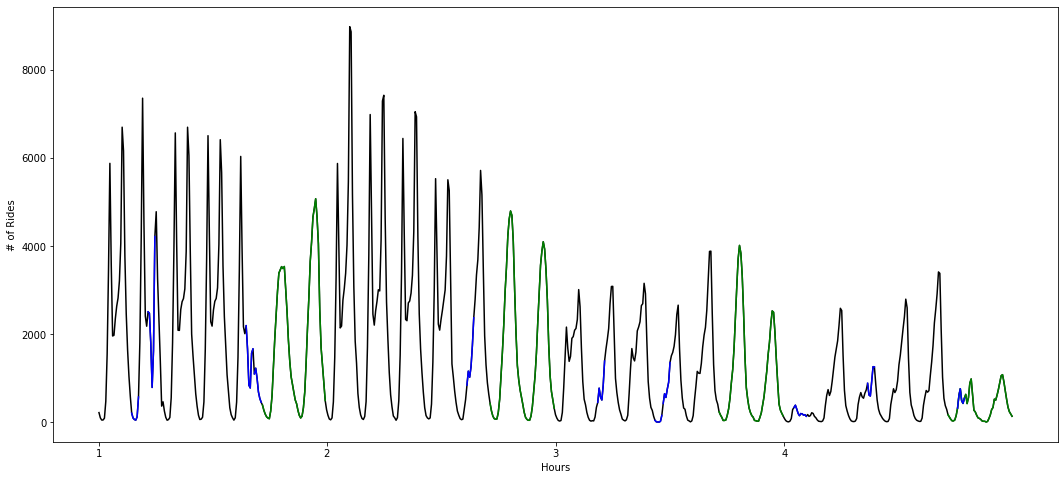

In [243]:
plt.figure(figsize=(18,8))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5))

_ = plt.xlabel('Hours')
_ = plt.ylabel('# of Rides')

In [226]:
24*30

720

In [204]:
len(full_month)

671

In [205]:
671-48

623